In [1]:
!pip install tensorflow==2.3.0
!pip install gym
!pip install keras
!pip install keras-rl2

In [44]:
import gym
from gym import Env
import random
from gym.spaces import Discrete, Box
import numpy as np
import random
from random import choice
import math
import FEA_SOLVER_TO_GENERAL

In [216]:
#Define The Size and Scope of Your Training
Lx=1
Ly=1
Elements_X=6
Elements_Y=6
if Elements_X%2!=0:
    Elements_X+=1
    Elements_Y+=1
ElementSize=Elements_X*Elements_Y
ElementNodes=FEA_SOLVER_TO_GENERAL.rectangularmesh(Lx,Ly,Elements_X,Elements_Y)[1]
nodeCoor=FEA_SOLVER_TO_GENERAL.rectangularmesh(Lx,Ly,Elements_X,Elements_Y)[0]
fixedNodeX=[i for i,x in enumerate(nodeCoor[:,0]) if x==0] 

No_Go_List=fixedNodeX
NGL=list([x + (Elements_X+1)*(Elements_Y+1) for x in fixedNodeX])
for i in range(0,len(NGL)):
    No_Go_List.append(NGL[i])

In [223]:
class TopOpt_6by6_General(Env):
    def __init__(self):
        #Actons we can take... remove any of the blocks
        self.action_space=Discrete(ElementSize)
        
        #Current Material Matrix
        self.observation_space=Box(np.array(-1*np.ones((1,ElementSize+5))),
                                   np.array((Elements_X+1)*(Elements_Y+1)*2*np.ones((1,ElementSize+5))))


        # Set Starting Material Matrix
        VoidCheck=np.ones((1,ElementSize))
        VoidCheck=list(VoidCheck[0])
        self.state = VoidCheck

        
    def step(self,action):
        #Apply Action
        '''Remove any blocks, but if it removes a boundary condition
        or a block that leads to a non-singular body, then the agent 
        should be penalized'''
        rs_place=self.state[action]
        self.state[action]=0
        ElementMat=np.reshape(self.state[:-5],(Elements_X,Elements_Y))
        SingleCheck=FEA_SOLVER_TO_GENERAL.isolate_largest_group_original(ElementMat)
        It=self.state.count(0)
        if rs_place==1 and action not in self.LeftBC and SingleCheck[1]==True:
            if It>=self.Remove_Tot:
                self.done=True 
                reward=10
            else:
                self.done=False
        
                reward=(FEA_SOLVER_TO_GENERAL.FEASolve(list(self.state),Lx,Ly,Elements_X,Elements_Y,
                                                    self.Loaded_Node, self.Load_Direction)[1])
                

                reward=(It/self.Remove_Tot)/reward[0][0]
    
        else: 
            """If the removed block has already been removed, leads to a non-singular
            body or one of the Boundary condition blocks, the agent should be severely punished (-100)"""
            reward=-1
            self.done=True
            
        #PLaceholder for Info
        info={}
        return self.state, reward, self.done, info
    
    def render(self, mode='human'):
        Render_Comments=self.state.count(0)
        if self.done is True:
            print('Desired Volume Fraction: '+str(self.Elements_Left)+'/'+str(ElementSize))
            if self.Load_Direction==1:
                if self.Loaded_Node>(Elements_X+1)*(Elements_Y+1):
                    print('\nThe vertically applied compressive load is on Node #'+ str(self.Loaded_Node-((Elements_X+1)*(Elements_Y+1)))+', a part of Element #'+ str(self.Loaded_Element))
                else:
                    print('\nThe horizontally applied compressive load is on Node #'+ str(self.Loaded_Node)+', a part of Element #'+ str(self.Loaded_Element))

            else:
                if self.Loaded_Node>(Elements_X+1)*(Elements_Y+1):
                    print('\nThe vertically applied tensile load is on Node #'+ str(self.Loaded_Node-((Elements_X+1)*(Elements_Y+1)))+', a part of Element #'+ str(self.Loaded_Element))
                else:
                    print('\nThe horizontally applied tensile load is on Node #'+ str(self.Loaded_Node)+', a part of Element #'+ str(self.Loaded_Element))
                    
            print('-----------------------------------')
            print('The final proposed solution is: \n')
        
        print('')
        ElementMat=np.reshape(self.state[:-5],(Elements_X,Elements_Y))
        print(ElementMat)
        
        
    def reset(self):
        self.done=False
        VoidCheck=np.ones((1,ElementSize))
        VoidCheck=list(VoidCheck[0])
        self.state = VoidCheck
        if self.Test is False:
            self.Loaded_Node=choice([i for i in range(0,(Elements_X+1)*(Elements_Y+1)*2) if i not in No_Go_List])
           
            self.Load_Direction=choice([-1,1]) #Train the agent for both tensile and compressive loading
            self.Elements_Left=choice([i for i in range(9,ElementSize-1)]) #Train the agent to design for any number of removed 
        else:
            print('You are testing this agent with predefined parameters.')
            
        if self.Loaded_Node> (Elements_X+1)*(Elements_Y+1):   
            self.Loaded_Element=np.where(ElementNodes==self.Loaded_Node-((Elements_X+1)*(Elements_Y+1)))[0][0]
            self.Load_Type=1
            self.Loaded_Loc=self.Loaded_Node-((Elements_X+1)-(Elements_Y+1))
        else:
            self.Loaded_Element=np.where(ElementNodes==self.Loaded_Node)[0][0]
            self.Load_Type=0
            self.Loaded_Loc=self.Loaded_Node
            
        #Extract the Row and Column of the Specific Node 
        self.Loaded_Row=math.floor(self.Loaded_Loc/(Elements_Y+1))
        self.Loaded_Col=((self.Loaded_Loc%(Elements_Y+1))*(Elements_Y+1))
                                   

        Vol_fraction=self.Elements_Left/(ElementSize)
        self.Remove_Tot=ElementSize-(ElementSize*Vol_fraction)
        self.LeftBC=list(range(0,Elements_X*(Elements_Y-1)*2,Elements_X*(Elements_Y-1)))
        self.LeftBC.append(self.Loaded_Element) #Randomly Assigned Applied Load
        self.state.append(self.Loaded_Row)
        self.state.append(self.Loaded_Col)
        self.state.append(self.Load_Type)  #1 if its vertically applied and 0 if its horizontally applied load 
        self.state.append(self.Load_Direction)
        self.state.append(self.Elements_Left)
        
        if self.Test is False:
            self.Loc_List.append(self.Loaded_Node)
            self.Dir_List.append(self.Load_Direction)
            self.Rem_List.append(self.Elements_Left)
        return self.state

In [224]:
env=TopOpt_6by6_General()

In [225]:
env.Loc_List=[]
env.Dir_List=[]
env.Rem_List=[]
episodes=4
env.Test=False
for episode in range(1,episodes+1):
    done=False
    score=0
    state=env.reset()
    while not done:
        
        action=random.randint(0,ElementSize-1)
        n_state,reward,done,info=env.step(action)
        env.render()
        It=n_state.count(0)
        score+=reward
    print('Episode: {} Score {} Completed Steps {}'.format(episode,score, It))
    print('')
    print('')


[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]

[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]

[[1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]

[[1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0.]]
Desired Volume Fraction: 25/36

The vertically applied compressive load is on Node #41, a part of Element #29
-----------------------------------
The final proposed solution is: 


[[1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0.]]
Episode: 1 Score -0.9965362071444049 Completed Steps 4



[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 

In [226]:
import numpy as np
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam



In [227]:
states=env.observation_space.shape
actions=env.action_space.n

In [228]:
del model

In [229]:
def build_model(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1,states[1])))
    model.add(Dense(60, activation='relu'))
    model.add(Dense(60, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [230]:
model=build_model(states,actions)

In [231]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 41)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 60)                2520      
_________________________________________________________________
dense_48 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_49 (Dense)             (None, 36)                2196      
Total params: 8,376
Trainable params: 8,376
Non-trainable params: 0
_________________________________________________________________


In [232]:
from rl.agents import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.policy import LinearAnnealedPolicy

In [233]:
def build_agent(model, actions):
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), 
                      attr='eps',
                      value_max=1.,
                      value_min=.05,
                      value_test=0,
                      nb_steps=250_000)
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions,gamma=0.7, nb_steps_warmup=5000,enable_double_dqn=True, enable_dueling_network=True, dueling_type='avg', target_model_update=1e-3)
    return dqn

In [234]:
env.Loc_List=[]
env.Dir_List=[]
env.Rem_List=[]
env.Test=False
env.reset()
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
train_rewards=dqn.fit(env, nb_steps=500_000, visualize=False, verbose=1)

Training for 500000 steps ...
Interval 1 (0 steps performed)
 1364/10000 [===>..........................] - ETA: 3:38 - reward: -0.1729done, took 34.609 seconds


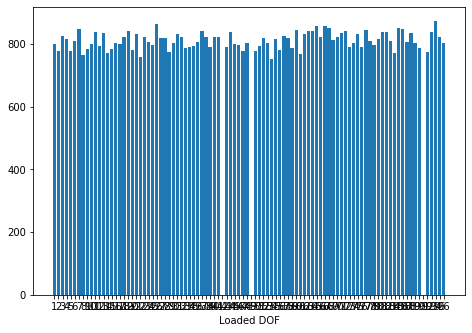

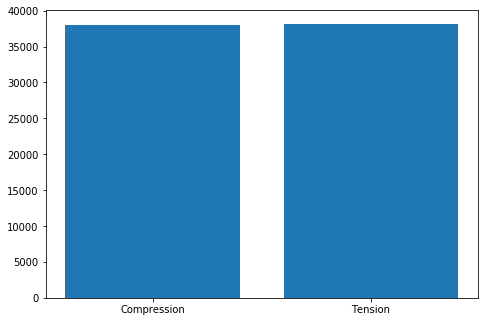

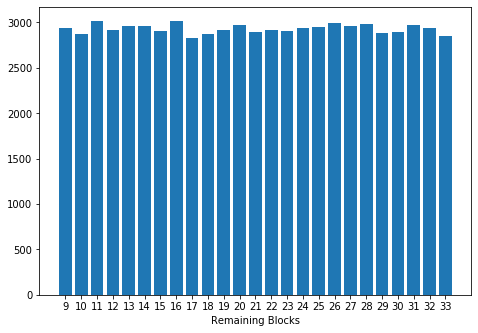

In [184]:
LL_plot=[]
DL_plot=[]
RL_plot=[]
LL_Label=[]
DL_Label=['Compression','Tension']
RL_Label=[]

for j in range(min(env.Loc_List),max(env.Loc_List)):
    LL_plot.append(env.Loc_List.count(j))
    
DL_plot.append(env.Dir_List.count(-1))
DL_plot.append(env.Dir_List.count(1))
    
for j in range(min(env.Rem_List),max(env.Rem_List)):
    RL_plot.append(env.Rem_List.count(j))
    
for j in range(min(env.Loc_List),max(env.Loc_List)):
    LL_Label.append(str(j))
    
for j in range(min(env.Rem_List),max(env.Rem_List)):
    RL_Label.append(str(j))
           
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(LL_Label,LL_plot)
plt.xlabel('Loaded DOF')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(DL_Label,DL_plot)
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(RL_Label,RL_plot)
plt.xlabel('Remaining Blocks')
plt.show()

In [183]:
# Loaded Node:   High Number Vertical    Lower Number Horizontal
# Load Direction: 1 Compression   -1 Tensile
env.Test=True

env.Loaded_Node=27
env.Load_Direction=-1
env.Elements_Left=11
scores = dqn.test(env, nb_episodes=1, visualize=True)
print(np.mean(scores.history['episode_reward']))

Testing for 1 episodes ...
You are testing this agent with predefined parameters.

[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]

[[1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]

[[1. 1. 1. 0. 1. 1.]
 [0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]

[[1. 1. 0. 0. 1. 1.]
 [0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]

[[1. 1. 0. 0. 1. 1.]
 [0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]

[[1. 1. 0. 0. 1. 1.]
 [0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1.]]

[[1. 1. 0. 0. 1. 1.]
 [0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1.]
 [0. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1.]]

[[1. 1. 0. 0. 1. 1.]


Text(0, 0.5, 'Average Reward Per Episode')

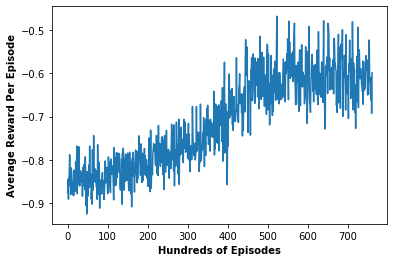

In [178]:
reward_plot = train_rewards.history['episode_reward']

import math
import matplotlib.pyplot as plt
len(reward_plot)
Dense=100
Plot_Reward=[]
for i in range(0,math.floor(len(reward_plot)/Dense)):
    Reward=reward_plot[i*Dense:(i+1)*Dense]
    mean_reward=np.mean(Reward)
    Plot_Reward.append(mean_reward)
plt.plot(Plot_Reward)
plt.xlabel('Hundreds of Episodes',fontweight='bold')
plt.ylabel('Average Reward Per Episode',fontweight='bold')

In [78]:
dqn.save_weights('TopOpt_6by6_weights', overwrite=False)

In [ ]:
dqn.load_weights('TopOpt_6by6_weights')

In [ ]:
_=dqn.test(env,nb_episodes=5,visualize=True)